# Data Preparation

## 0. Import Library and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from datetime import datetime
import re

JSON data looks like below:

`{"reward": 10, 
"channels": ["email", "mobile", "social"], 
"difficulty": 10, "duration": 7.0, 
"offer_type": "bogo", 
"id": "ae264e3637204a6fb9bb56bc8210ddfd"}`

From [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html), we can use `'record'` as orient value.

In [2]:
data_dir = r'..\data\raw\\'
df_portfolio = pd.read_json(data_dir+'portfolio.json', orient='records', lines=True)
df_profile = pd.read_json(data_dir+'profile.json', orient='records', lines=True)
df_transcript = pd.read_json(data_dir+'transcript.json', orient='records', lines=True)

## 1. Inspect Profile Dataframe

### 1.a. Take a look of the data

In [3]:
df_profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [4]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
df_profile.nunique()

gender                  3
age                    85
id                  17000
became_member_on     1716
income                 91
dtype: int64

From sample and information of the data above we know that: 
* There are some Null data in Gender and Income column. <br>
* Age and income are numerical value, gender is categorical value, and became_member_on is datetime value but still in the numerical type. 
* There is no duplicate id from profile

### 1.b. Handling Null Data

In [6]:
null = df_profile[df_profile['gender'].isnull()]
print('There are {len_null} rows which is {perc_null:.2f}% of the data'.format(len_null=len(null), perc_null=(len(null)/len(df_profile)*100)) )
null.sample(10)

There are 2175 rows which is 12.79% of the data


,gender,age,id,became_member_on,income
13556,None,118,35e187f77aed4f54824dce156b7d7a6e,20180211,NaN
172,None,118,50b92ea51e2649dfbf7120d5e554e991,20180114,NaN
13999,None,118,6342d5f0912e4bb4a0ba4d21436e8e8b,20170411,NaN
14920,None,118,6beb1072bbd5438c83dd0bde66d7261d,20180702,NaN
619,None,118,df6fd073309e42ecb1ab53d3daa6e13b,20160429,NaN
15908,None,118,2c8adcf84d1643628f893c2084e3d3fd,20171211,NaN
3521,None,118,75da6707b8824502852123cf9e6d353e,20180517,NaN
14201,None,118,a812a119dbab4d5095fa34d49b67a208,20180718,NaN
6446,None,118,6b098efe833b45e49590ec30f64dabe0,20180614,NaN
9350,None,118,45f37b268a36476ea205bed02a7ecf17,20171006,NaN


From the view above we get that all rows which has Null for gender columns is also has null in income and has 118 in age (which is so sus). <br>
Since the number is sufficient large, we can't handling by replacing with mean/median. Instead, we will remove all the Null data.

In [7]:
df_profile = df_profile[df_profile['gender'].notnull()].reset_index(inplace=False)
df_profile = df_profile.drop(df_profile.columns[0], axis=1)
df_profile.sample(5)

,gender,age,id,became_member_on,income
3279,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0
3703,M,34,9a9a6f44405f49fdb0c3fa45109767d5,20141115,31000.0
2678,F,86,1ed4a5aa68d441f9b6b3fc2af09e76e1,20171207,79000.0
7467,M,62,84075839276d4b06a2b842001e527822,20180312,56000.0
3553,F,60,6b55fde85bdd4ed088a6fb7399c4ae99,20171115,58000.0


### 1.c. Date Formating

In [8]:
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')
df_profile['bmo_year'] = df_profile.apply(lambda row:row['became_member_on'].strftime('%Y'), axis=1)

print(df_profile.info())
df_profile.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   bmo_year          14825 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 695.0+ KB
None


,gender,age,id,became_member_on,income,bmo_year
14284,M,55,f3934f05d51f47c7a470661cbb774075,2016-05-08,40000.0,2016
1619,M,47,e7147567b7de4eb4a0ca7d48a3388855,2017-08-06,53000.0,2017
7224,F,75,0e1ba2f7bef34c4788328679e52fd56c,2017-06-13,60000.0,2017
8002,F,57,fda1e716a8d94a679231f1c89c5cb64d,2017-09-28,95000.0,2017
12401,F,50,65fe3e1feeb1458abd54d955820572ec,2016-08-21,80000.0,2016


## 2. Inspect Transcript Data

### 2.a. Take a look at the data

In [9]:
df_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [10]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
df_transcript['person'].nunique()

17000

From sample data above, we know that each person will have more than one rows which contain offer process (received, viewed, and completed) and transaction amount.<br>
We need to extract information of offer id and the amount of transaction from the value column.

### 2.b. Get Offer Data

In [12]:
df_offer = df_transcript[df_transcript['event']!='transaction']

pattern = re.compile("{'.+': '([a-z0-9]+)'.*}")
df_offer.loc[:,'offer id'] = df_offer.loc[:,'value'].apply(lambda row: pattern.findall(str(row))[0]) 

pattern2= re.compile("{.+'reward': (\d{1})}")
df_offer.loc[:,'reward'] = df_offer.loc[:,'value'].apply(lambda row: pattern2.findall(str(row)))

df_offer.loc[:,'reward'] = df_offer.loc[:,'reward'].apply(lambda row: row[0] if len(row)>0 else np.nan) 
df_offer = df_offer.drop(columns='value')
df_offer

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,person,event,time,offer id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2


### 2.c. Get Transaction Data

In [13]:
df_transaction = df_transcript[df_transcript['event']=='transaction']

pattern = re.compile("{'amount': ([0-9.]+)}")
df_transaction.loc[:,'amount'] = df_transaction.loc[:,'value'].apply(lambda row: pattern.findall(str(row))[0])
df_transaction.loc[:,'amount']=df_transaction.loc[:,'amount'].astype('float')

df_transaction = df_transaction.drop(columns = 'value')
df_transaction

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,person,event,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53


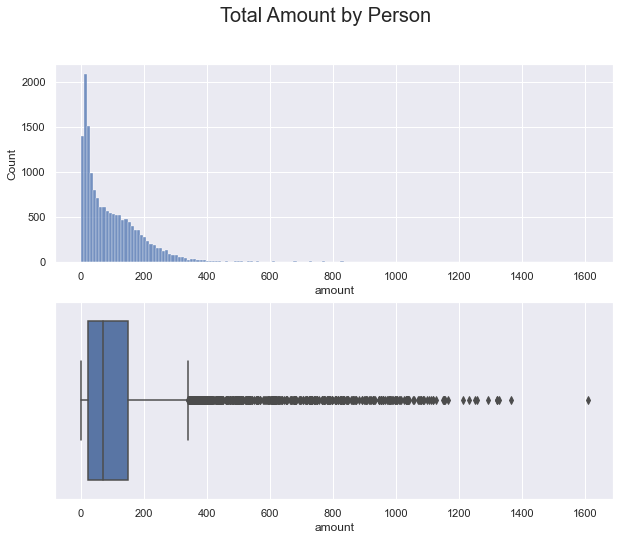

In [14]:
fig_dir = r'..\result\figure\\'
fig_title = 'Total Amount by Person'

df_persontrans = pd.DataFrame(df_transaction.groupby('person').sum()['amount'])
df_persontrans = df_persontrans.reset_index(inplace=False)

fig, axs = plt.subplots(2,1, figsize=(10,8))
fig.suptitle(fig_title, fontsize=20)

sns.histplot(x=df_persontrans['amount'],ax=axs[0])
sns.boxplot(x=df_persontrans['amount'],ax=axs[1])
plt.show()

### 2.d. Combine Offer and Transaction Data

In [15]:
df_transcript = pd.concat([df_offer,df_transaction])
df_transcript

,person,event,time,offer id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,NaN,3.53


## 3. Inspect Portfolio Data

### 3.a. Take a Look at The Data

In [16]:
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [17]:
df_portfolio = df_portfolio.sort_values(by=['offer_type','duration','difficulty'], ascending=True)

offer_name = []

for i in range(len(df_portfolio)):
    name = 'Offer {0:d}' .format(i)
    offer_name.append(name)
    
df_portfolio['offer_name'] = offer_name

df_portfolio

,reward,channels,difficulty,duration,offer_type,id,offer_name
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,Offer 0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,Offer 1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,Offer 2
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,Offer 3
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,Offer 4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,Offer 5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,Offer 6
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,Offer 7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,Offer 8
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,Offer 9


There are only 10 rows from the portfolio table. Each rows (must be) coresspond with offer id from previous table. <br>
Since the id is too long that make us difficult to recognize the offer, we add new column called 'offer_name' to tag each offer with number.

## 4. Combine All Data

* Profile can be merged with Transcript using id and person column respectively. To filter not complete person, we use **left** join.
* The above table can be merged with portfolio by offer id and id columns. To make sure there are no data from larger table left behind, we use **left** join also.

In [18]:
df = df_profile.merge(df_transcript, left_on='id', right_on='person', how='left')
df = df.merge(df_portfolio, left_on='offer id', right_on='id', how='left')
df = df.drop(columns=['id_x','id_y'])
df.sample(10)

,gender,age,became_member_on,income,bmo_year,person,event,time,offer id,reward_x,amount,reward_y,channels,difficulty,duration,offer_type,offer_name
167004,M,51,2016-01-10,116000.0,2016,ad2c5a7237a647d5b717fc079283da18,offer received,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,"[web, email]",20.0,10.0,discount,Offer 7
104989,F,27,2017-02-28,34000.0,2017,a14c2517450542f4b55c2c13901e21ca,transaction,474,NaN,NaN,3.77,NaN,NaN,NaN,NaN,NaN,NaN
19438,M,58,2016-05-25,75000.0,2016,bc0adc37f9ed446ea17b6dd30e1e88d7,transaction,552,NaN,NaN,15.07,NaN,NaN,NaN,NaN,NaN,NaN
187485,M,42,2015-10-23,63000.0,2015,39df77129bb648a4a7de07edea1df461,transaction,492,NaN,NaN,2.75,NaN,NaN,NaN,NaN,NaN,NaN
152999,M,51,2016-11-14,63000.0,2016,d03e159b7fbd4da9a87fd265f02720a0,offer received,504,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,"[web, email, mobile]",0.0,4.0,informational,Offer 9
92691,O,31,2018-04-10,37000.0,2018,4177c85d48f047e29db682c8f87aaac8,transaction,330,NaN,NaN,10.47,NaN,NaN,NaN,NaN,NaN,NaN
178494,M,25,2017-10-10,40000.0,2017,ebf0ac82b55d436bb6a53ccf910cd759,offer completed,594,2298d6c36e964ae4a3e7e9706d1fb8c2,3,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount,Offer 4
75903,M,43,2015-03-15,52000.0,2015,a1cdc184a3ff4b57a37670c88d26eca9,transaction,708,NaN,NaN,1.68,NaN,NaN,NaN,NaN,NaN,NaN
122096,M,50,2017-10-06,76000.0,2017,1885c809d58447988f532ff93c41d8e5,transaction,0,NaN,NaN,16.58,NaN,NaN,NaN,NaN,NaN,NaN
92837,F,61,2016-01-31,91000.0,2016,39200c5f788949ea9293c4bdbfd89767,offer viewed,714,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount,Offer 5


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   gender            272762 non-null  object        
 1   age               272762 non-null  int64         
 2   became_member_on  272762 non-null  datetime64[ns]
 3   income            272762 non-null  float64       
 4   bmo_year          272762 non-null  object        
 5   person            272762 non-null  object        
 6   event             272762 non-null  object        
 7   time              272762 non-null  int64         
 8   offer id          148805 non-null  object        
 9   reward_x          25477 non-null   object        
 10  amount            123957 non-null  float64       
 11  reward_y          148805 non-null  float64       
 12  channels          148805 non-null  object        
 13  difficulty        148805 non-null  float64       
 14  dura

## 5. Export Cleansed Data

In [20]:
cleansed_dir = r'..\data\cleansed\\'
file_name = 'data.csv'

df.to_csv(cleansed_dir+file_name, index=False, header=True)

We will explore deeper about the data in the next notebook :).